<a href="https://colab.research.google.com/github/azizdafi/Cloud-Cover-Detection/blob/main/Cloud_Cover_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Cloud Cover Detection



##### **Project Type**    - DL-CNN

# **Project Summary -**

Write the summary here within 500-600 words.

# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


**Create a Vision Transformer (ViT) based model capable of accurately identifying and effectively masking clouds in multispectral satellite imagery, per pixel. These models should significantly elevate the quality of input data for Earth surface analysis, specifically benefiting analytical tasks reliant on accurate cloud removal and detection.**

Link to the dataset in multiple forms, as well as reference paper :
https://www.kaggle.com/datasets/hmendonca/cloud-cover-detection

# **General Guidelines** : -  

1.   Well-structured, formatted, and commented code is required.
2.   Exception Handling, Production Grade Code & Deployment Ready Code will be a plus. Those students will be awarded some additional credits.
     
     The additional credits will have advantages over other students during Star Student selection.
       
             [ Note: - Deployment Ready Code is defined as, the whole .ipynb notebook should be executable in one go
                       without a single error logged. ]

3.   Each and every logic should have proper comments.
4. You may add as many number of charts you want. Make Sure for each and every chart the following format should be answered.
        

```
# Chart visualization code
```
            

*   Why did you pick the specific chart?
*   What is/are the insight(s) found from the chart?
* Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

5. You have to create at least 15 logical & meaningful charts having important insights.


[ Hints : - Do the Vizualization in  a structured way while following "UBM" Rule.

U - Univariate Analysis,

B - Bivariate Analysis (Numerical - Categorical, Numerical - Numerical, Categorical - Categorical)

M - Multivariate Analysis
 ]





6. You may add more ml algorithms for model creation. Make sure for each and every algorithm, the following format should be answered.


*   Explain the ML Model used and it's performance using Evaluation metric Score Chart.


*   Cross- Validation & Hyperparameter Tuning

*   Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

*   Explain each evaluation metric's indication towards business and the business impact pf the ML model used.




















# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno


#setting font size throughout the notebook
plt.rcParams.update({'font.size': 14})



### Dataset Loading

In [2]:
# Load Dataset
! pip install -q kaggle
from google.colab import files
print("Upload the kagle json file")
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json



Upload the kagle json file


Saving kaggle.json to kaggle.json


In [3]:
# ! kaggle competitions download -d 'hmendonca/cloud-cover-detection'
!kaggle datasets download -d hmendonca/cloud-cover-detection

100% 16.2G/16.2G [14:04<00:00, 19.2MB/s]
100% 16.2G/16.2G [14:04<00:00, 20.6MB/s]


In [4]:
!unzip cloud-cover-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_labels/phdv.tif  
  inflating: data/train_labels/pheu.tif  
  inflating: data/train_labels/phfl.tif  
  inflating: data/train_labels/phfr.tif  
  inflating: data/train_labels/phfv.tif  
  inflating: data/train_labels/phgh.tif  
  inflating: data/train_labels/phhg.tif  
  inflating: data/train_labels/phhx.tif  
  inflating: data/train_labels/phio.tif  
  inflating: data/train_labels/phje.tif  
  inflating: data/train_labels/phjk.tif  
  inflating: data/train_labels/phlf.tif  
  inflating: data/train_labels/phli.tif  
  inflating: data/train_labels/phlj.tif  
  inflating: data/train_labels/phmg.tif  
  inflating: data/train_labels/phmo.tif  
  inflating: data/train_labels/phnk.tif  
  inflating: data/train_labels/phog.tif  
  inflating: data/train_labels/phqs.tif  
  inflating: data/train_labels/phro.tif  
  inflating: data/train_labels/phss.tif  
  inflating: data/train_labels/phux.tif  
  inflating: data/train_l

### Dataset First View

In [5]:
# Dataset First Look
df = pd.read_csv("/content/train_metadata.csv", parse_dates = ['datetime'])
# df = pd.read_csv("/content/train_metadata.csv")
df.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj


### Dataset Rows & Columns count

In [6]:
# Dataset Rows & Columns count
x = df.shape
print(f'the dataset has {x[0]} rows and {x[1]} columns')

the dataset has 11748 rows and 4 columns


### Dataset Information

In [7]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11748 entries, 0 to 11747
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   chip_id    11748 non-null  object             
 1   location   11748 non-null  object             
 2   datetime   11748 non-null  datetime64[ns, UTC]
 3   cloudpath  11748 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 367.2+ KB


#### Duplicate Values

In [8]:
# Dataset Duplicate Value Count
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 0


#### Missing Values/Null Values

In [9]:
# Missing Values/Null Values Count
missing_values = df.isna().sum()
print(missing_values)

chip_id      0
location     0
datetime     0
cloudpath    0
dtype: int64


<Axes: >

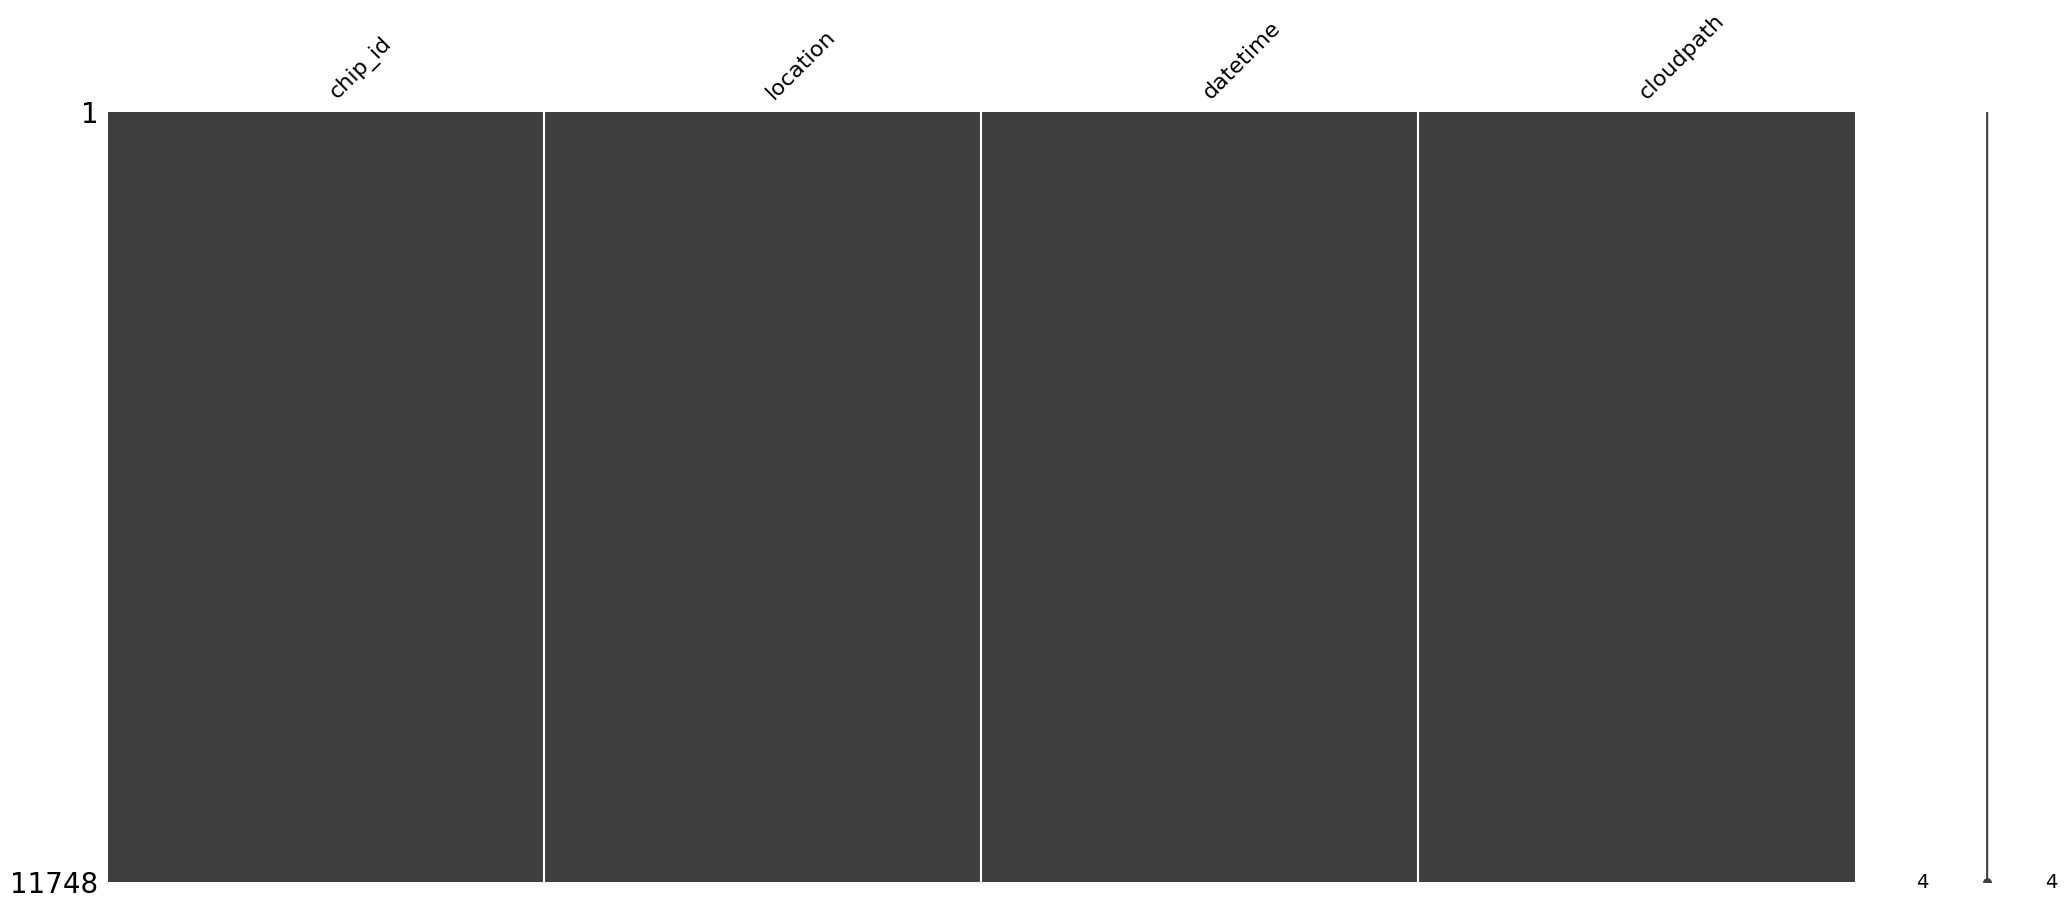

In [10]:
# Visualizing the missing values
msno.matrix(df)

### What did you know about your dataset?

Answer Here

## ***2. Understanding Your Variables***

In [11]:
# Dataset Columns
col = df.columns
print(col)

Index(['chip_id', 'location', 'datetime', 'cloudpath'], dtype='object')


In [12]:
# Dataset Describe
df.describe().T

<ipython-input-12-8e46f779bc6a>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe().T


,count,unique,top,freq,first,last
chip_id,11748,11748,adwp,1,NaT,NaT
location,11748,81,Chifunfu,341,NaT,NaT
datetime,11748,91,2020-09-06 15:02:37+00:00,261,2018-03-07 08:46:02+00:00,2020-09-14 08:28:49+00:00
cloudpath,11748,11748,az://./train_features/adwp,1,NaT,NaT


### Variables Description

Answer Here

### Check Unique Values for each variable.

In [13]:
# Check Unique Values for each variable and listing values whose count is less than 25
for column in df.columns:
  res = len(df[column].unique())
  print(f"The number of unique variables in {column} column are: {res}")

The number of unique variables in chip_id column are: 11748
The number of unique variables in location column are: 81
The number of unique variables in datetime column are: 91
The number of unique variables in cloudpath column are: 11748


## 3. ***Data Wrangling***

### Data Wrangling Code

In [14]:
# Write your code to make your dataset analysis ready.

### What all manipulations have you done and insights you found?

Answer Here.

In [15]:
df_orignal = df.copy()

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

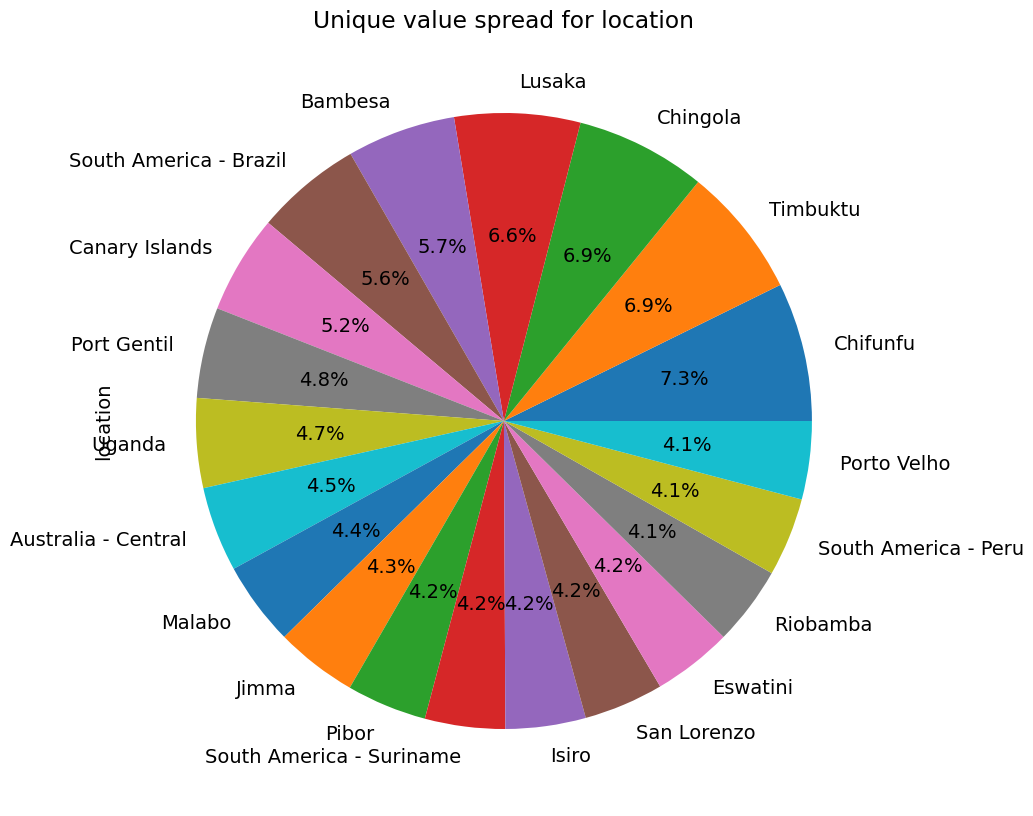

In [20]:
# Chart - 1 visualization code
# df.head()
spread = df['location'].value_counts().head(20)
plt.rcParams['figure.figsize'] = (10,10)

  # pictdistance 0.6 is set to display the value inside the chart, if set more than 1, it'll display outside the chart.
spread.plot(kind = 'pie', autopct='%1.1f%%', pctdistance=0.6)

  #setting colum chart title
plt.title(f'Unique value spread for location')
plt.show()


<Axes: >

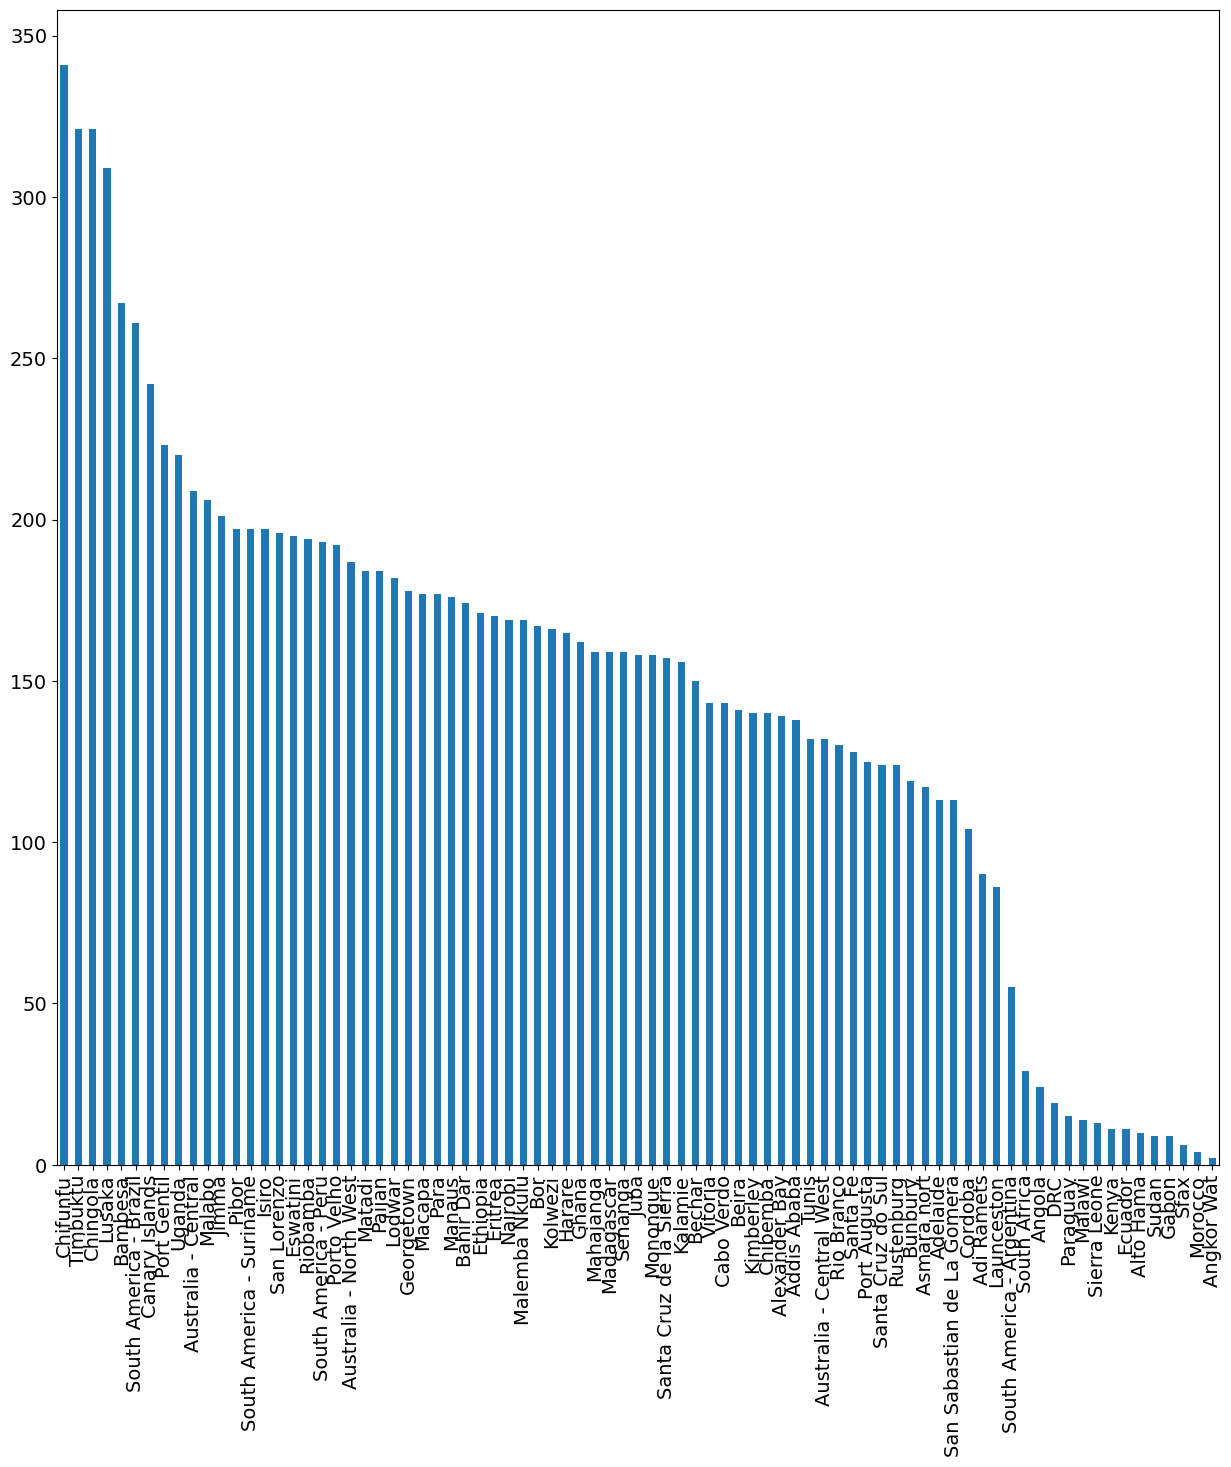

In [17]:
spread.plot.bar()

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 2

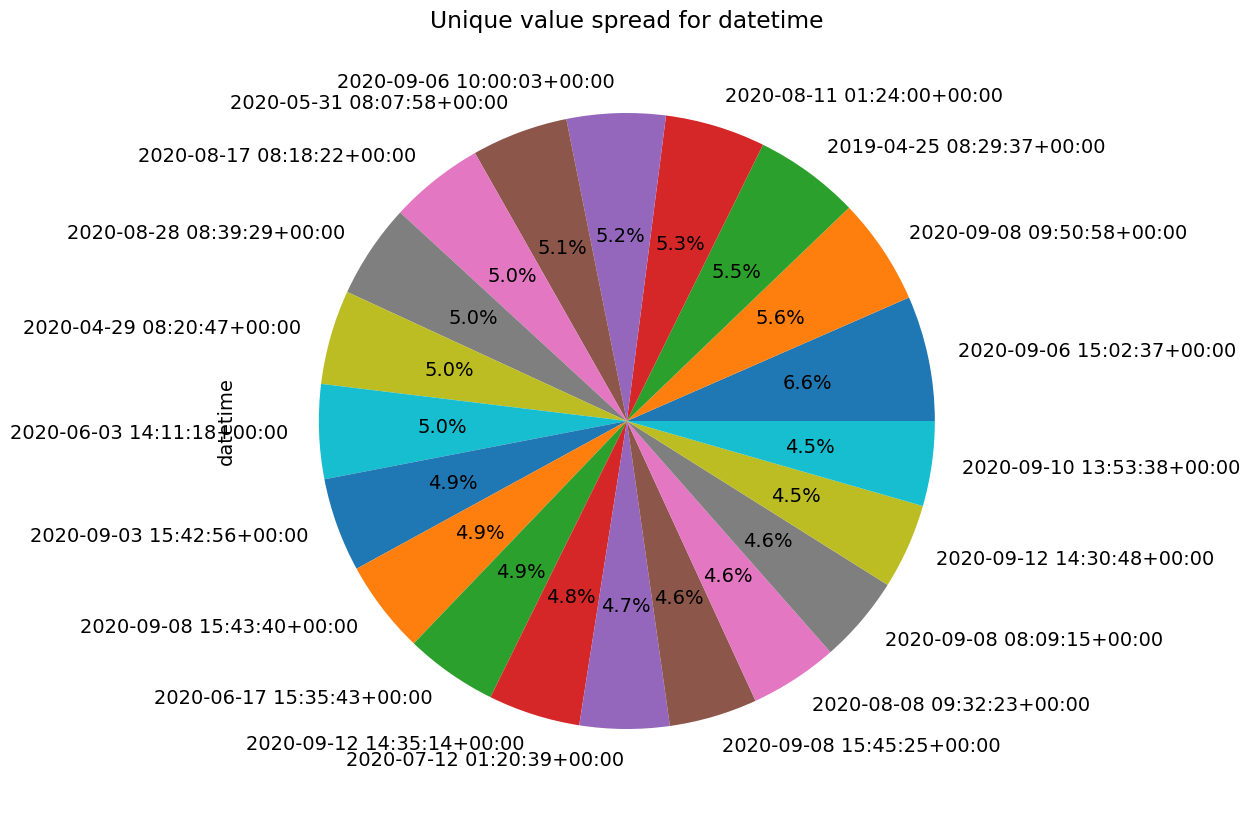

In [22]:
# Chart - 2 visualization code
# df.head()
spread = df['datetime'].value_counts().head(20)
plt.rcParams['figure.figsize'] = (10,10)

  # pictdistance 0.6 is set to display the value inside the chart, if set more than 1, it'll display outside the chart.
spread.plot(kind = 'pie', autopct='%1.1f%%', pctdistance=0.6)

  #setting colum chart title
plt.title(f'Unique value spread for datetime')
plt.show()

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 3

In [ ]:
# Chart - 3 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 4

In [ ]:
# Chart - 4 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 5

In [ ]:
# Chart - 5 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 6

In [ ]:
# Chart - 6 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 7

In [ ]:
# Chart - 7 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 8

In [ ]:
# Chart - 8 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 9

In [ ]:
# Chart - 9 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 10

In [ ]:
# Chart - 10 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 11

In [ ]:
# Chart - 11 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 12

In [ ]:
# Chart - 12 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 13

In [ ]:
# Chart - 13 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 14 - Correlation Heatmap

In [ ]:
# Correlation Heatmap visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 15 - Pair Plot

In [ ]:
# Pair Plot visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

Answer Here.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [ ]:
# Handling Missing Values & Missing Value Imputation

#### What all missing value imputation techniques have you used and why did you use those techniques?

Answer Here.

### 2. Handling Outliers

In [ ]:
# Handling Outliers & Outlier treatments

##### What all outlier treatment techniques have you used and why did you use those techniques?

Answer Here.

### 3. Categorical Encoding

In [ ]:
# Encode your categorical columns

#### What all categorical encoding techniques have you used & why did you use those techniques?

Answer Here.

### 4. Textual Data Preprocessing
(It's mandatory for textual dataset i.e., NLP, Sentiment Analysis, Text Clustering etc.)

#### 1. Expand Contraction

In [ ]:
# Expand Contraction

#### 2. Lower Casing

In [ ]:
# Lower Casing

#### 3. Removing Punctuations

In [ ]:
# Remove Punctuations

#### 4. Removing URLs & Removing words and digits contain digits.

In [ ]:
# Remove URLs & Remove words and digits contain digits

#### 5. Removing Stopwords & Removing White spaces

In [ ]:
# Remove Stopwords

In [ ]:
# Remove White spaces

#### 6. Rephrase Text

In [ ]:
# Rephrase Text

#### 7. Tokenization

In [ ]:
# Tokenization

#### 8. Text Normalization

In [ ]:
# Normalizing Text (i.e., Stemming, Lemmatization etc.)

##### Which text normalization technique have you used and why?

Answer Here.

#### 9. Part of speech tagging

In [ ]:
# POS Taging

#### 10. Text Vectorization

In [ ]:
# Vectorizing Text

##### Which text vectorization technique have you used and why?

Answer Here.

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [ ]:
# Manipulate Features to minimize feature correlation and create new features

#### 2. Feature Selection

In [ ]:
# Select your features wisely to avoid overfitting

##### What all feature selection methods have you used  and why?

Answer Here.

##### Which all features you found important and why?

Answer Here.

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

In [ ]:
# Transform Your data

### 6. Data Scaling

In [ ]:
# Scaling your data

##### Which method have you used to scale you data and why?

### 7. Dimesionality Reduction

##### Do you think that dimensionality reduction is needed? Explain Why?

Answer Here.

In [ ]:
# DImensionality Reduction (If needed)

##### Which dimensionality reduction technique have you used and why? (If dimensionality reduction done on dataset.)

Answer Here.

### 8. Data Splitting

In [ ]:
# Split your data to train and test. Choose Splitting ratio wisely.

##### What data splitting ratio have you used and why?

Answer Here.

### 9. Handling Imbalanced Dataset

##### Do you think the dataset is imbalanced? Explain Why.

Answer Here.

In [ ]:
# Handling Imbalanced Dataset (If needed)

##### What technique did you use to handle the imbalance dataset and why? (If needed to be balanced)

Answer Here.

## ***7. ML Model Implementation***

### ML Model - 1

In [ ]:
# ML Model - 1 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### ML Model - 2

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

#### 3. Explain each evaluation metric's indication towards business and the business impact pf the ML model used.

Answer Here.

### ML Model - 3

In [ ]:
# ML Model - 3 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

Answer Here.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

Answer Here.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

Answer Here.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [ ]:
# Save the File

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [ ]:
# Load the File and predict unseen data.

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

Write the conclusion here.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***